# Preparing the environment


## Libraries

In [1]:
#%pip install adjustText
#%pip install --upgrade kaleido

In [2]:
# requirements
import pandas as pd
import scripts.eta_analysis as eta
import scripts.ra_analysis as ra

C:\Users\loren\Projetos_Antigos\api-health-monitor\notebooks\3-results\scripts\eta_analysis.py:123: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  axes[0].set(xlabel="", ylabel="$\eta$")


## Results Analysis

Load the resulting datasets from experiment phase.

In [3]:
df_eta = pd.read_csv("../2-experiments/outputs/kalman_eta_results.csv")
df_k = pd.read_csv("../2-experiments/outputs/kalman_k_results.csv")
df_q = pd.read_csv("../2-experiments/outputs/kalman_q_results.csv")
df_r = pd.read_csv("../2-experiments/outputs/kalman_r_results.csv")
df_ra_win = pd.read_csv("../2-experiments/outputs/kalman_ra_win_results.csv")
anomalous_traffic_win_observations_df = pd.read_csv(
    "../0-datasets/treated_dataset/anomalous_traffic_win_observations.csv")

Converting the timestamp column to datetime, easing it manipulation and aritmetics.

In [4]:
df_k['window_start'] = pd.to_datetime(df_k['window_start'])
df_q['window_start'] = pd.to_datetime(df_q['window_start'])
df_r['window_start'] = pd.to_datetime(df_r['window_start'])
df_ra_win['window_start'] = pd.to_datetime(df_ra_win['window_start'])
anomalous_traffic_win_observations_df['time_local'] = pd.to_datetime(anomalous_traffic_win_observations_df['time_local'])

In [5]:
FIXED_WINDOW=120

### $\eta$ evaluation

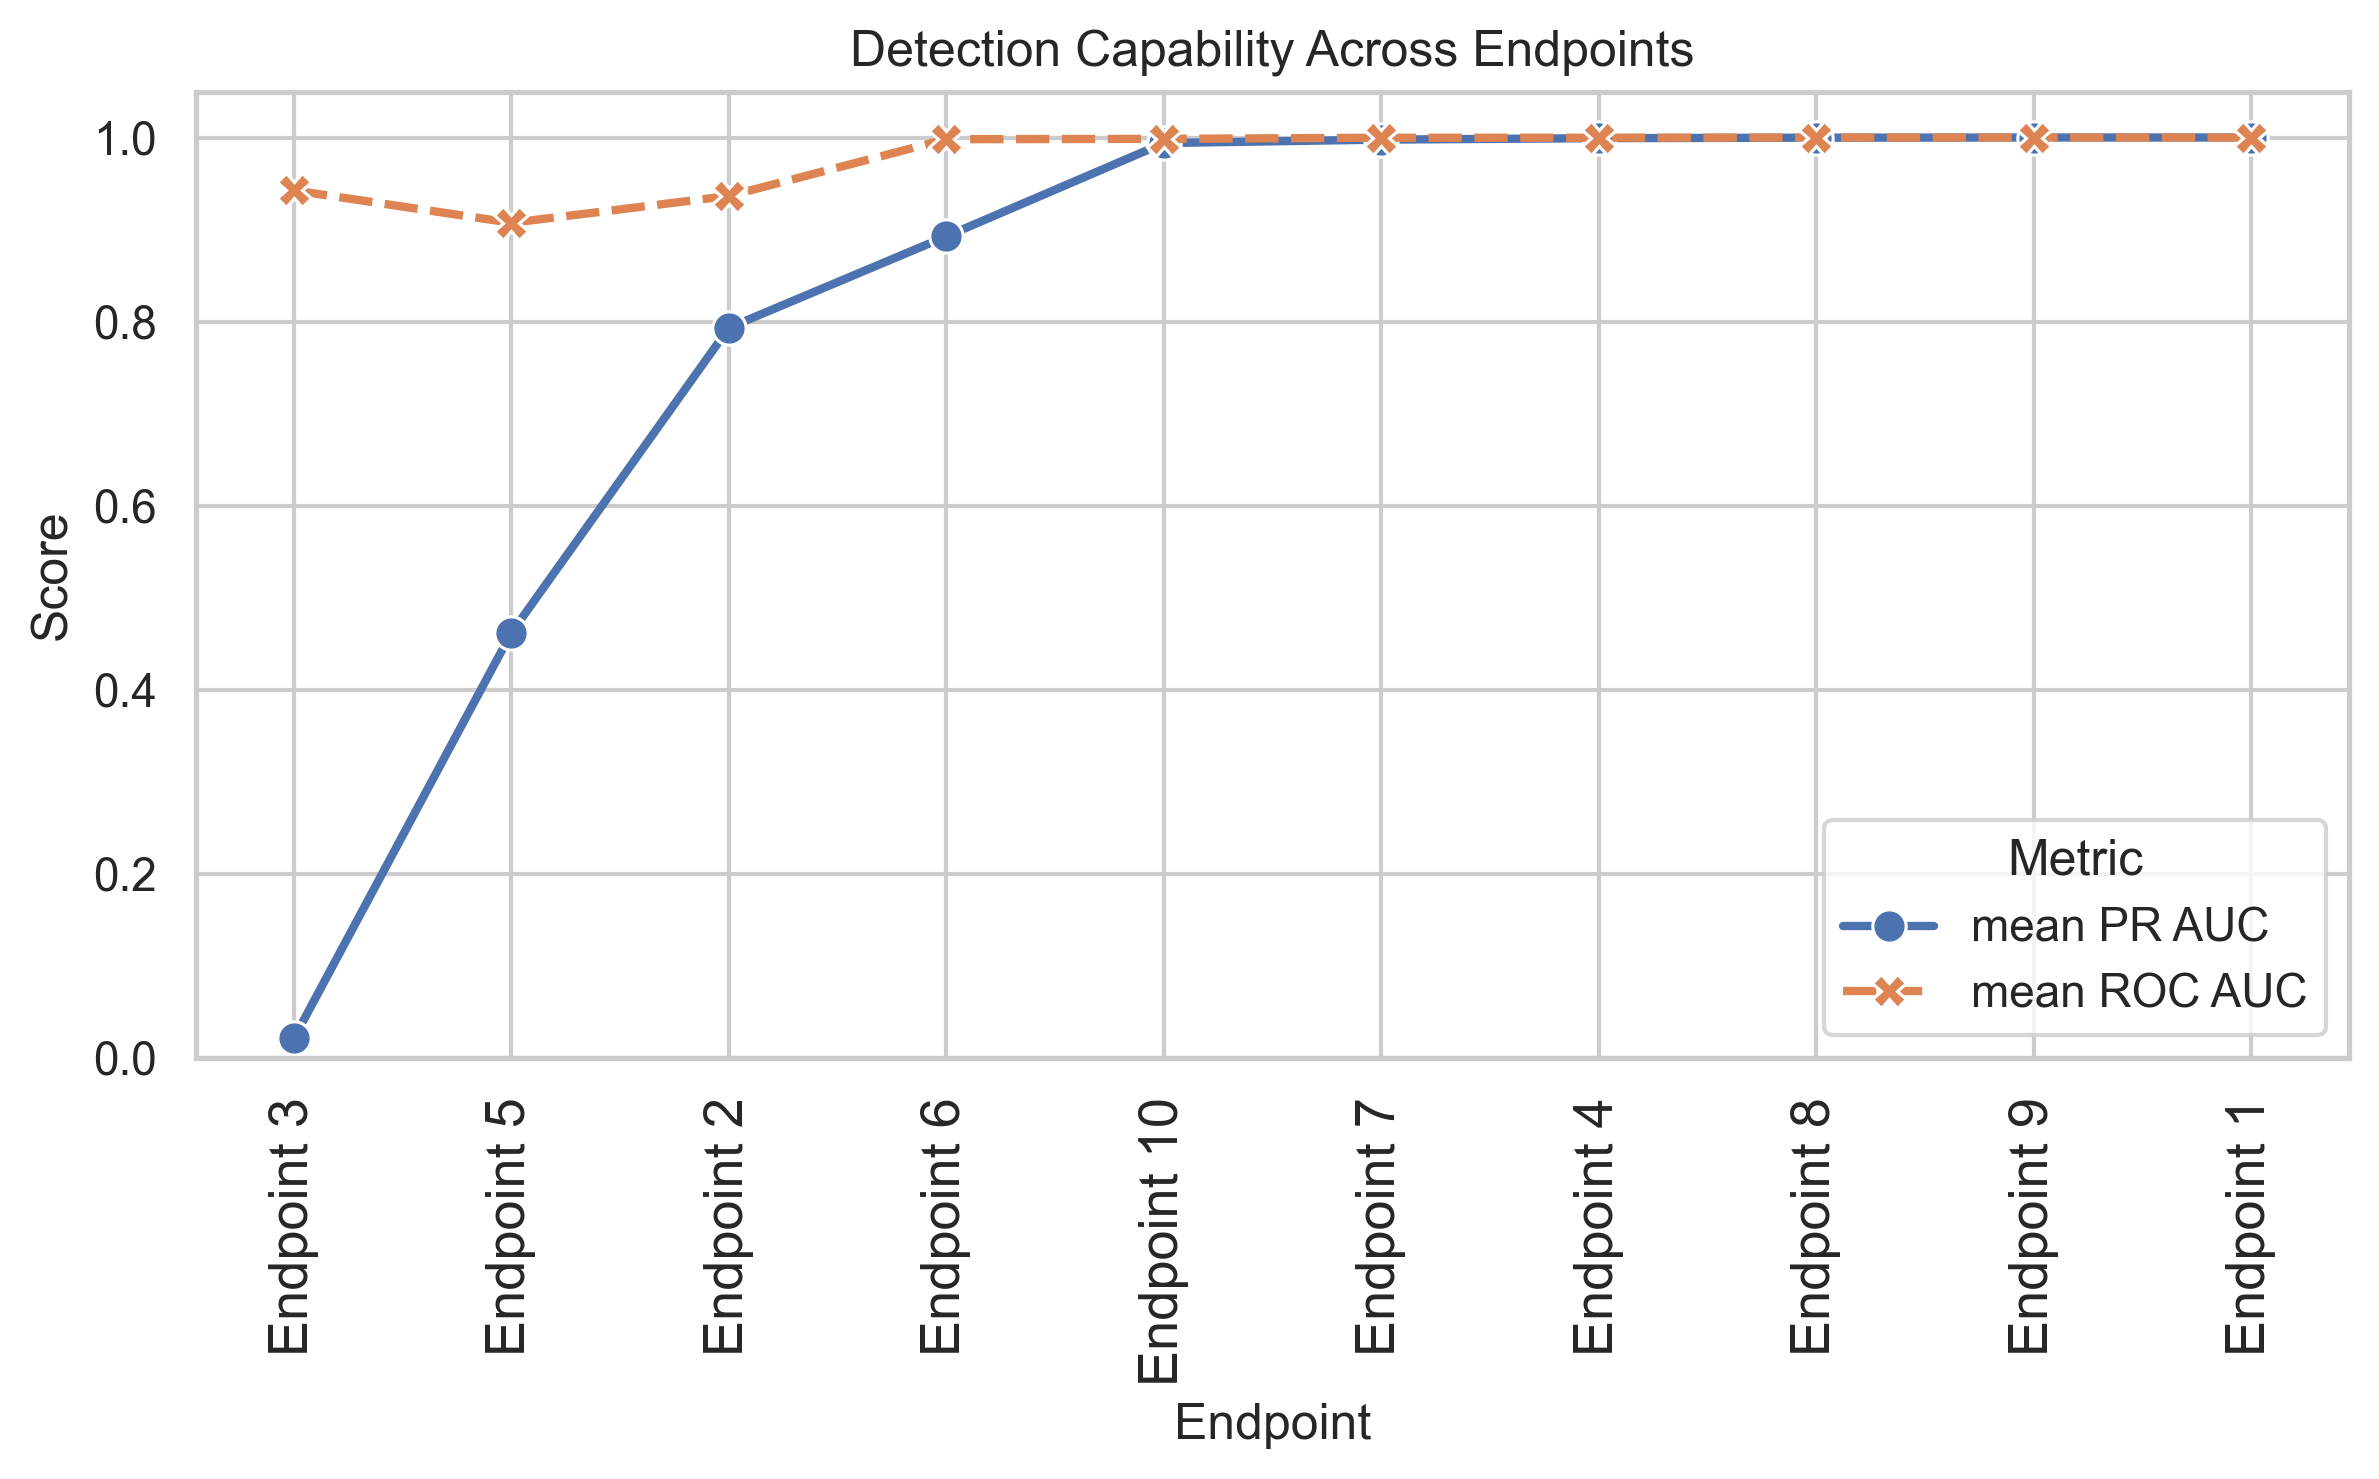

In [6]:
df_eta_metrics = eta.compute_classification_metrics(df_eta)
eta.plot_detection_capability(df_eta_metrics, figsize=(8, 5))

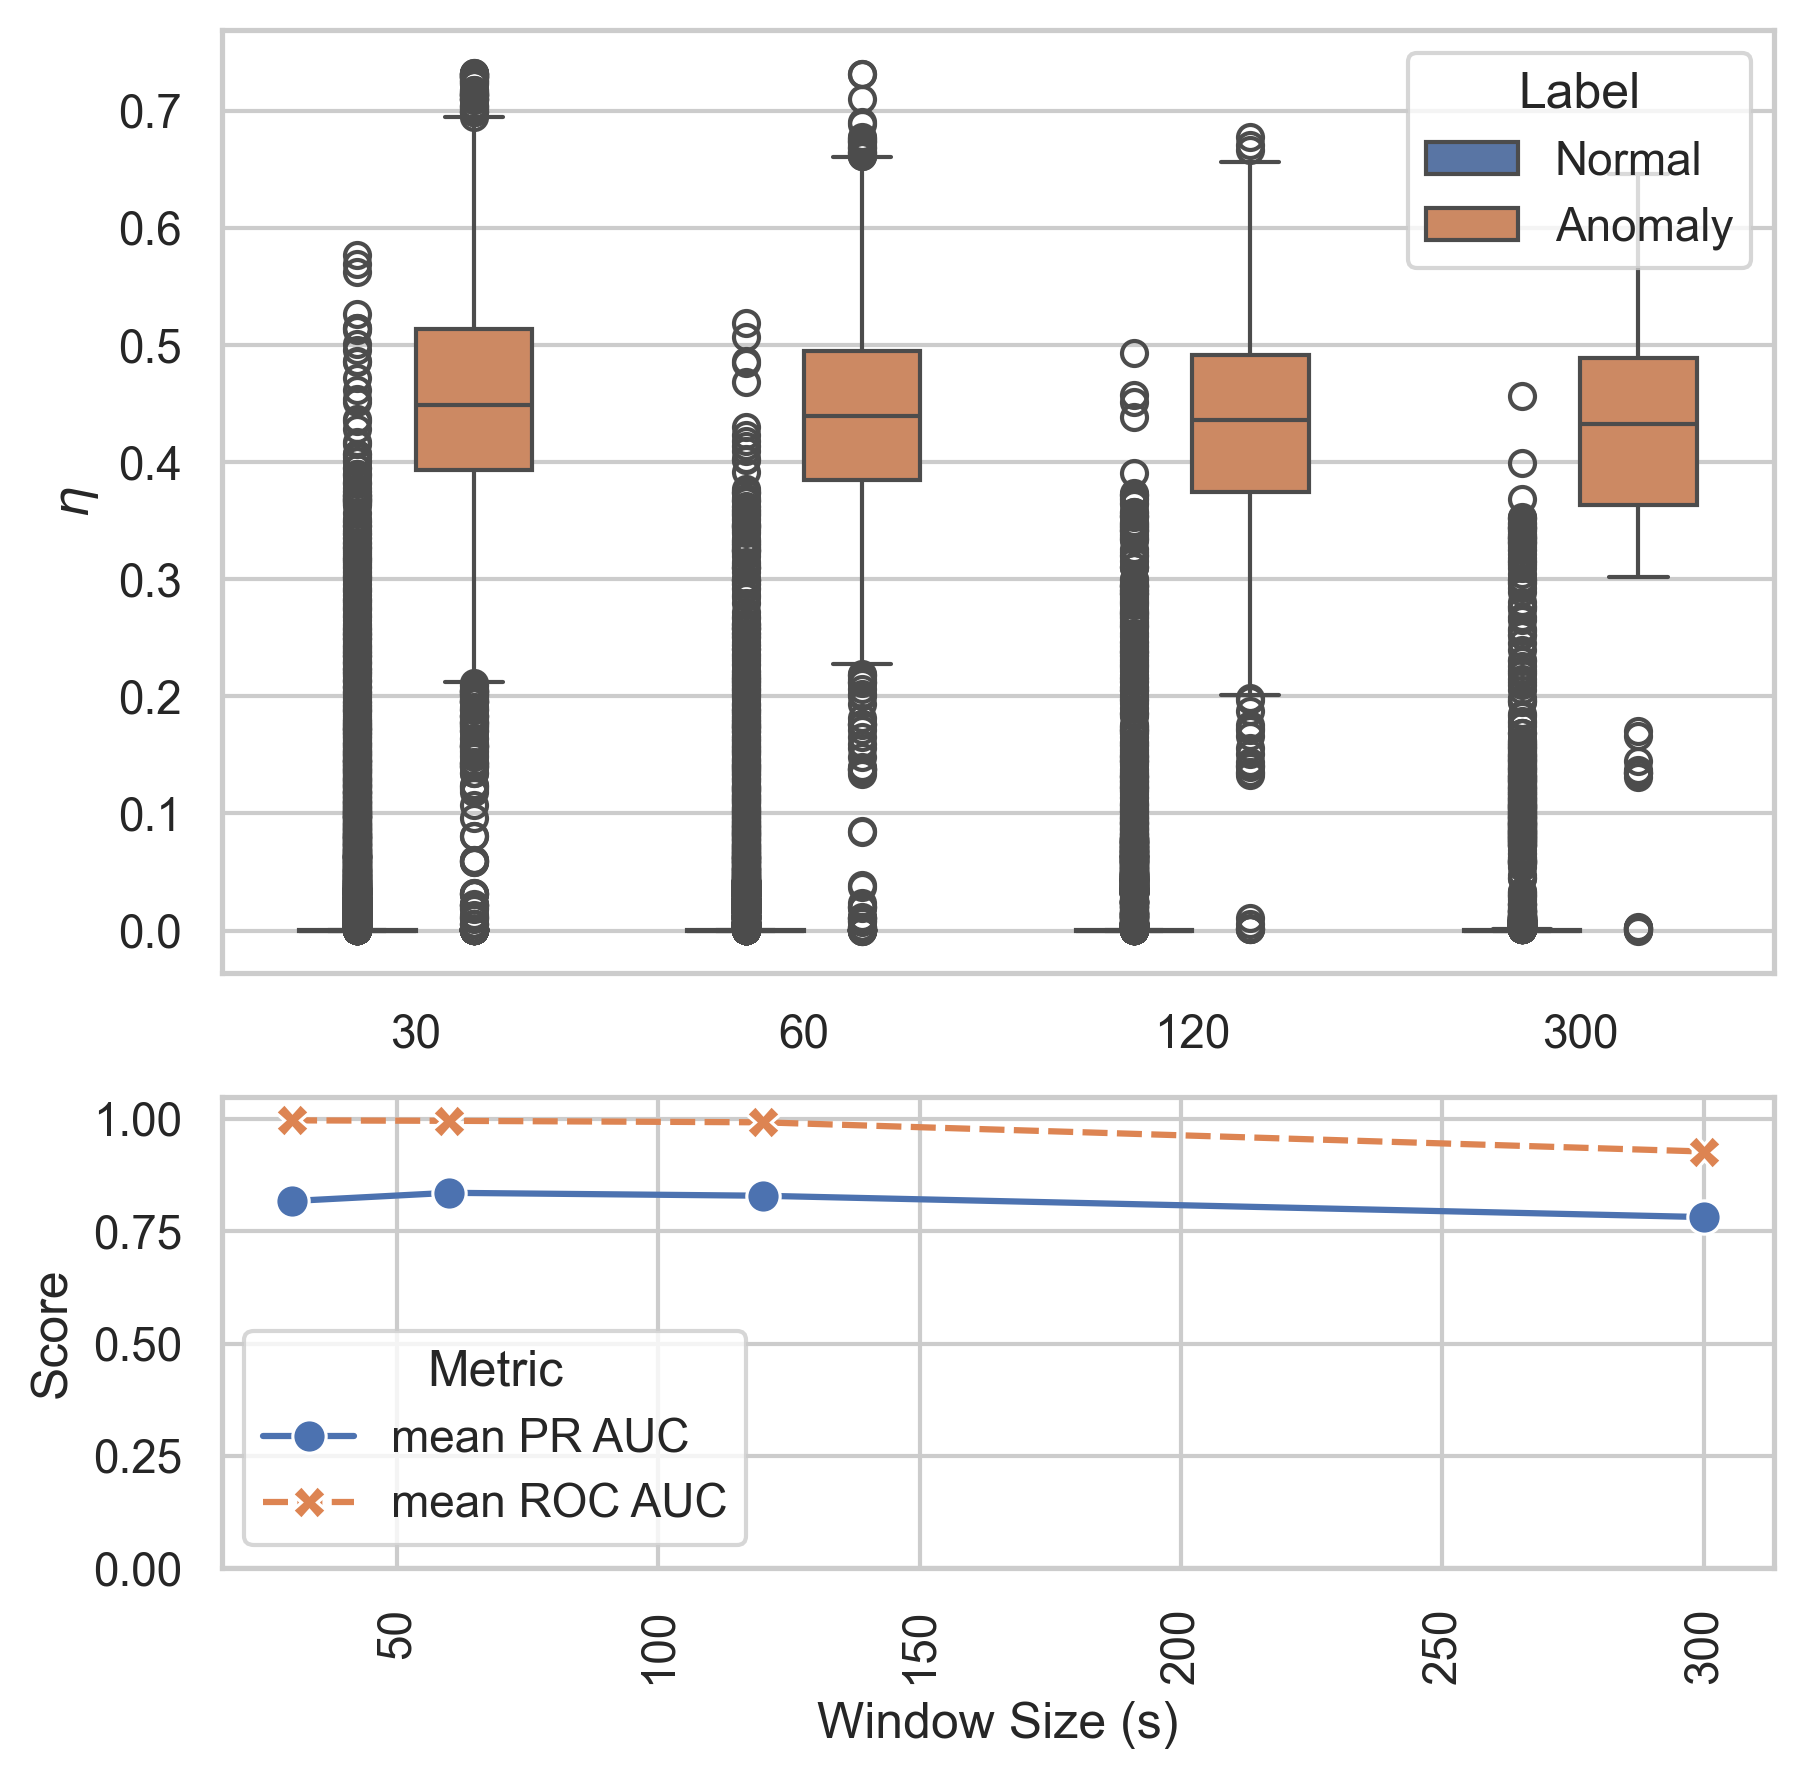

In [7]:
eta.plot_combined_analysis(df_eta_metrics, df_eta, figsize=(6, 6))

In [8]:
eta.get_summary_stats(df_eta_metrics)

Mean       Std       Min  Max
ROC_AUC  0.978253  0.067532  0.666667  1.0
PR_AUC   0.815986  0.320323  0.014085  1.0

In [9]:
eta.get_summary_stats(df_eta_metrics, group_by=["window_size"])

window_size   ROC_AUC                             PR_AUC            \
                   mean       std       min  max      mean       std   
0          30  0.996939  0.006925  0.977643  1.0  0.817415  0.335483   
1          60  0.995924  0.009632  0.969349  1.0  0.835710  0.334410   
2         120  0.992590  0.015946  0.954023  1.0  0.829188  0.325397   
3         300  0.927560  0.124695  0.666667  1.0  0.781631  0.335303   

                  
        min  max  
0  0.014085  1.0  
1  0.020408  1.0  
2  0.027027  1.0  
3  0.023810  1.0

### Ra Evaluation

Sensitivity analysis was conducted by independently varying
the observation sensitivity parameter k, process noise Q,
and observation noise R, while fixing the temporal aggregation window
to 30 seconds.

A separate analysis was conducted to evaluate robustness across
different window sizes.


Measured properties:
- Sensibility: how Ra responds to anomaly
- Ratio: if Ra responds more anomalies bigger
- Memory: if Ra is integrating along the time
- Robust: if it is consistent for different values of k, Q, R

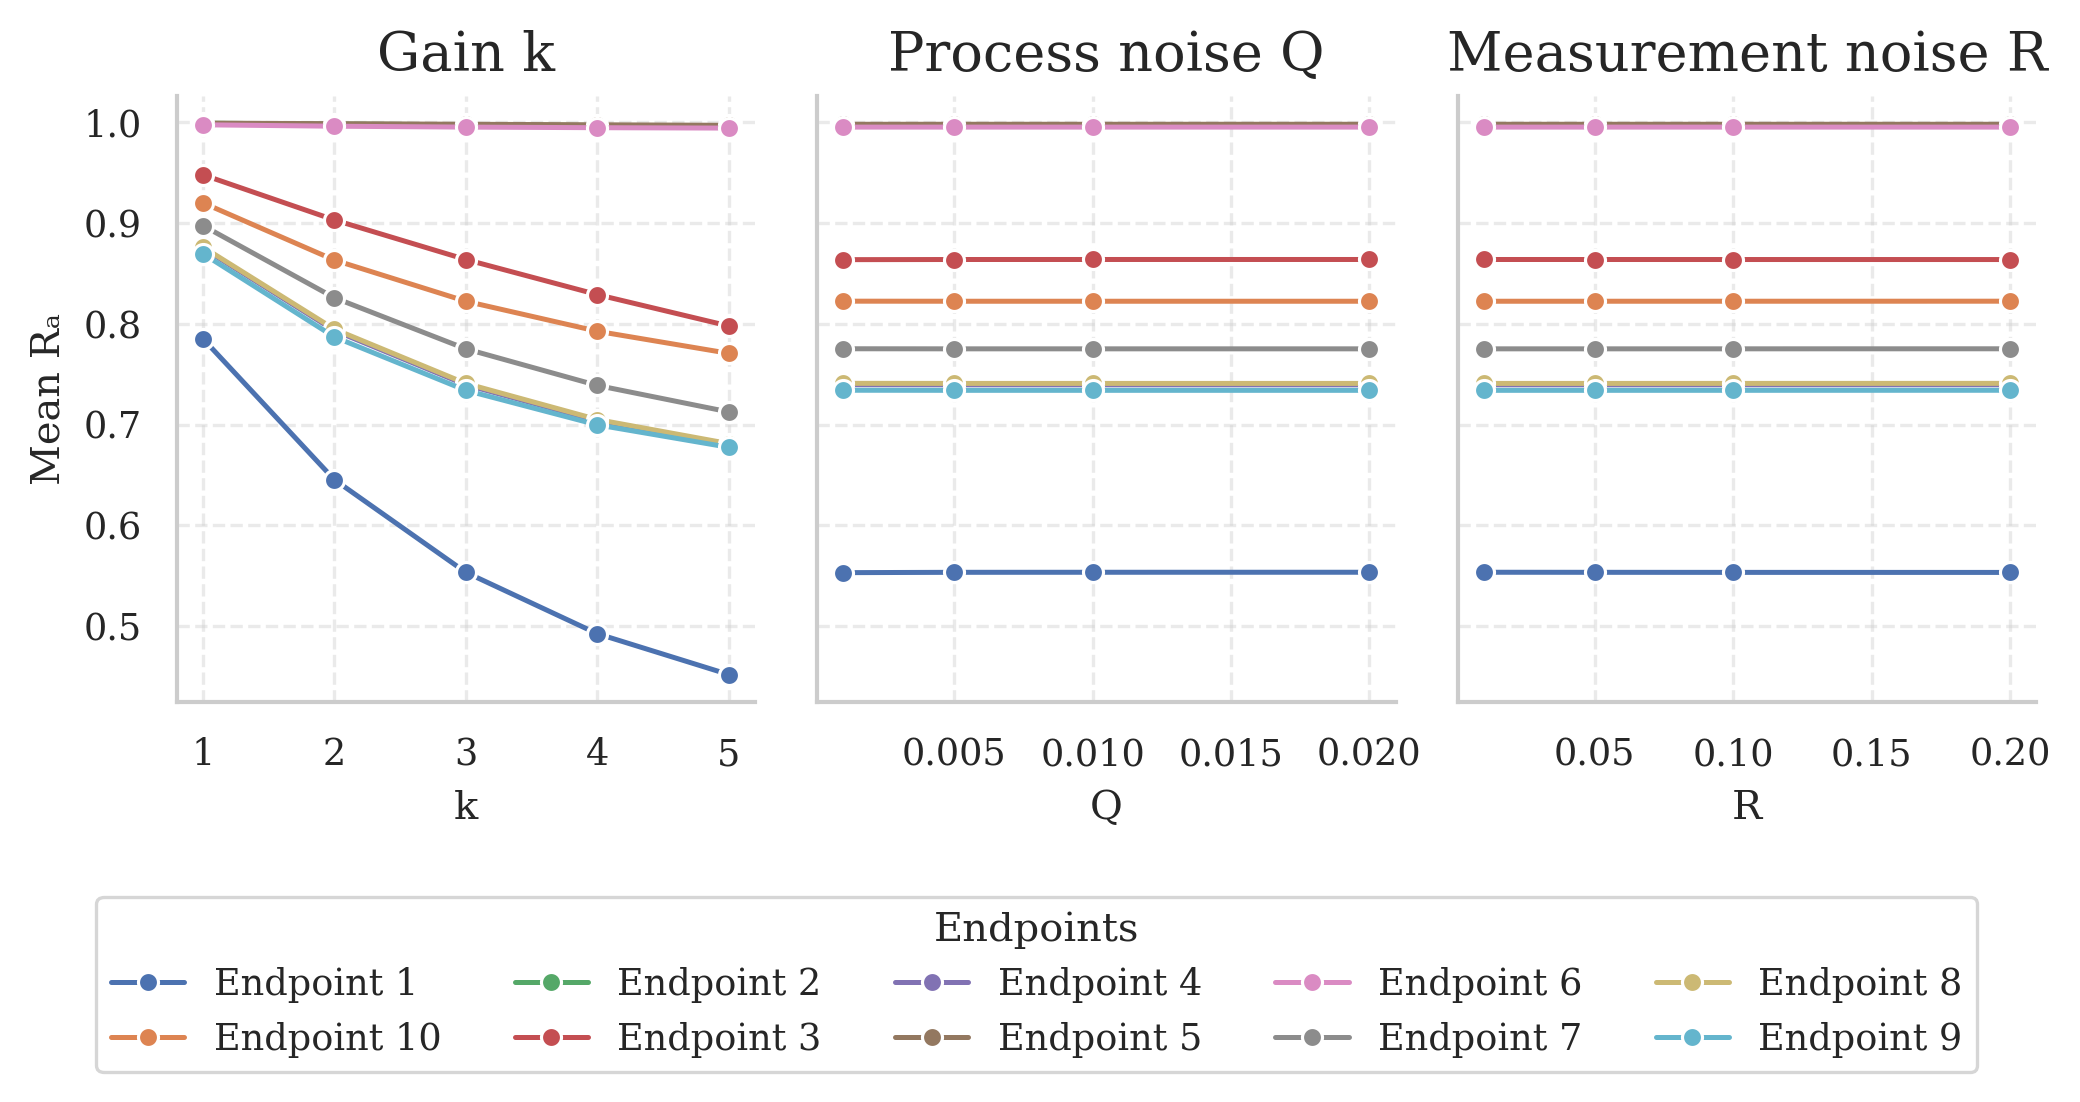

In [10]:
ra.plot_ra_vs_kalman_params_grid(df_k=df_k, df_R=df_r, df_Q=df_q)

Ra in response to anomaly events

The endpoint-specific visualization confirms that the relationship between anomaly score and health degradation is consistent across all monitored services. While minor differences in degradation magnitude are observed due to endpoint-specific traffic dynamics and anomaly persistence, all endpoints exhibit the same monotonic functional response. This demonstrates that the proposed Kalman-based health indicator is robust and generalizable across heterogeneous traffic profiles.

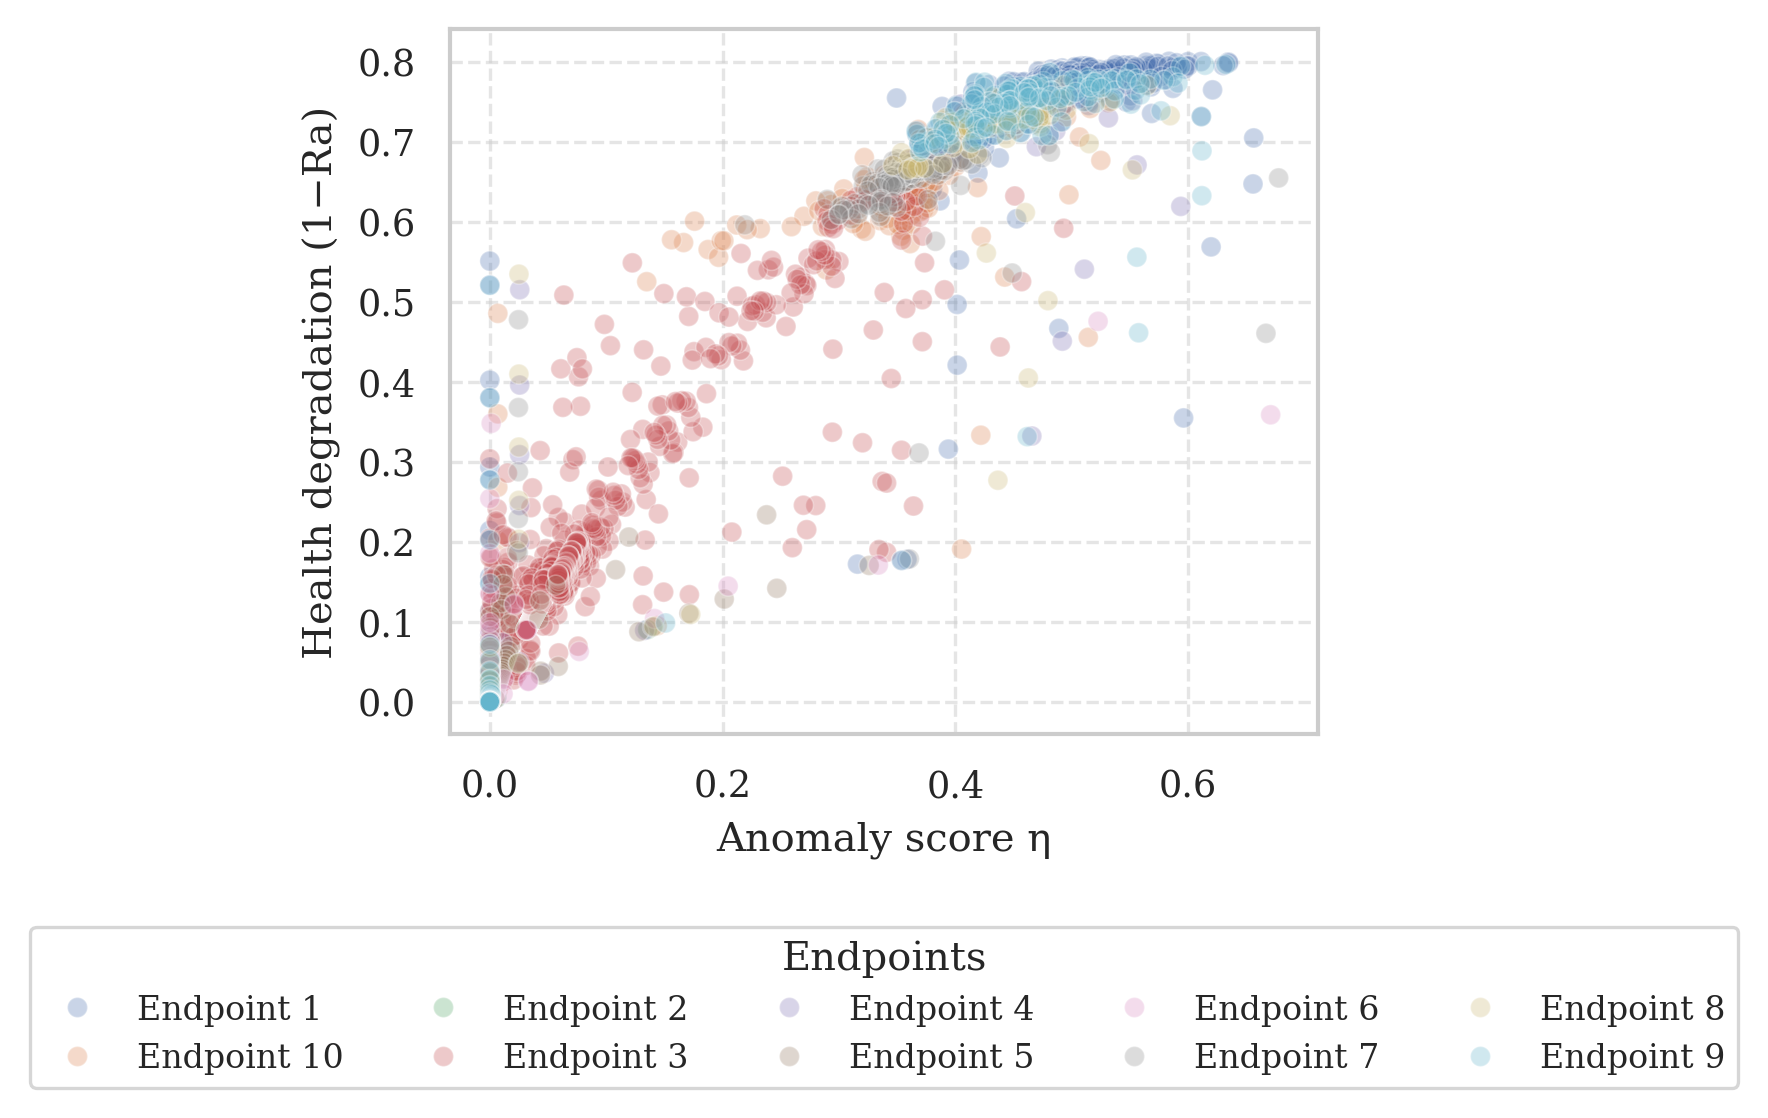

In [11]:
ra.plot_ra_vs_eta(df_ra_win[df_ra_win['window_size'] == FIXED_WINDOW])

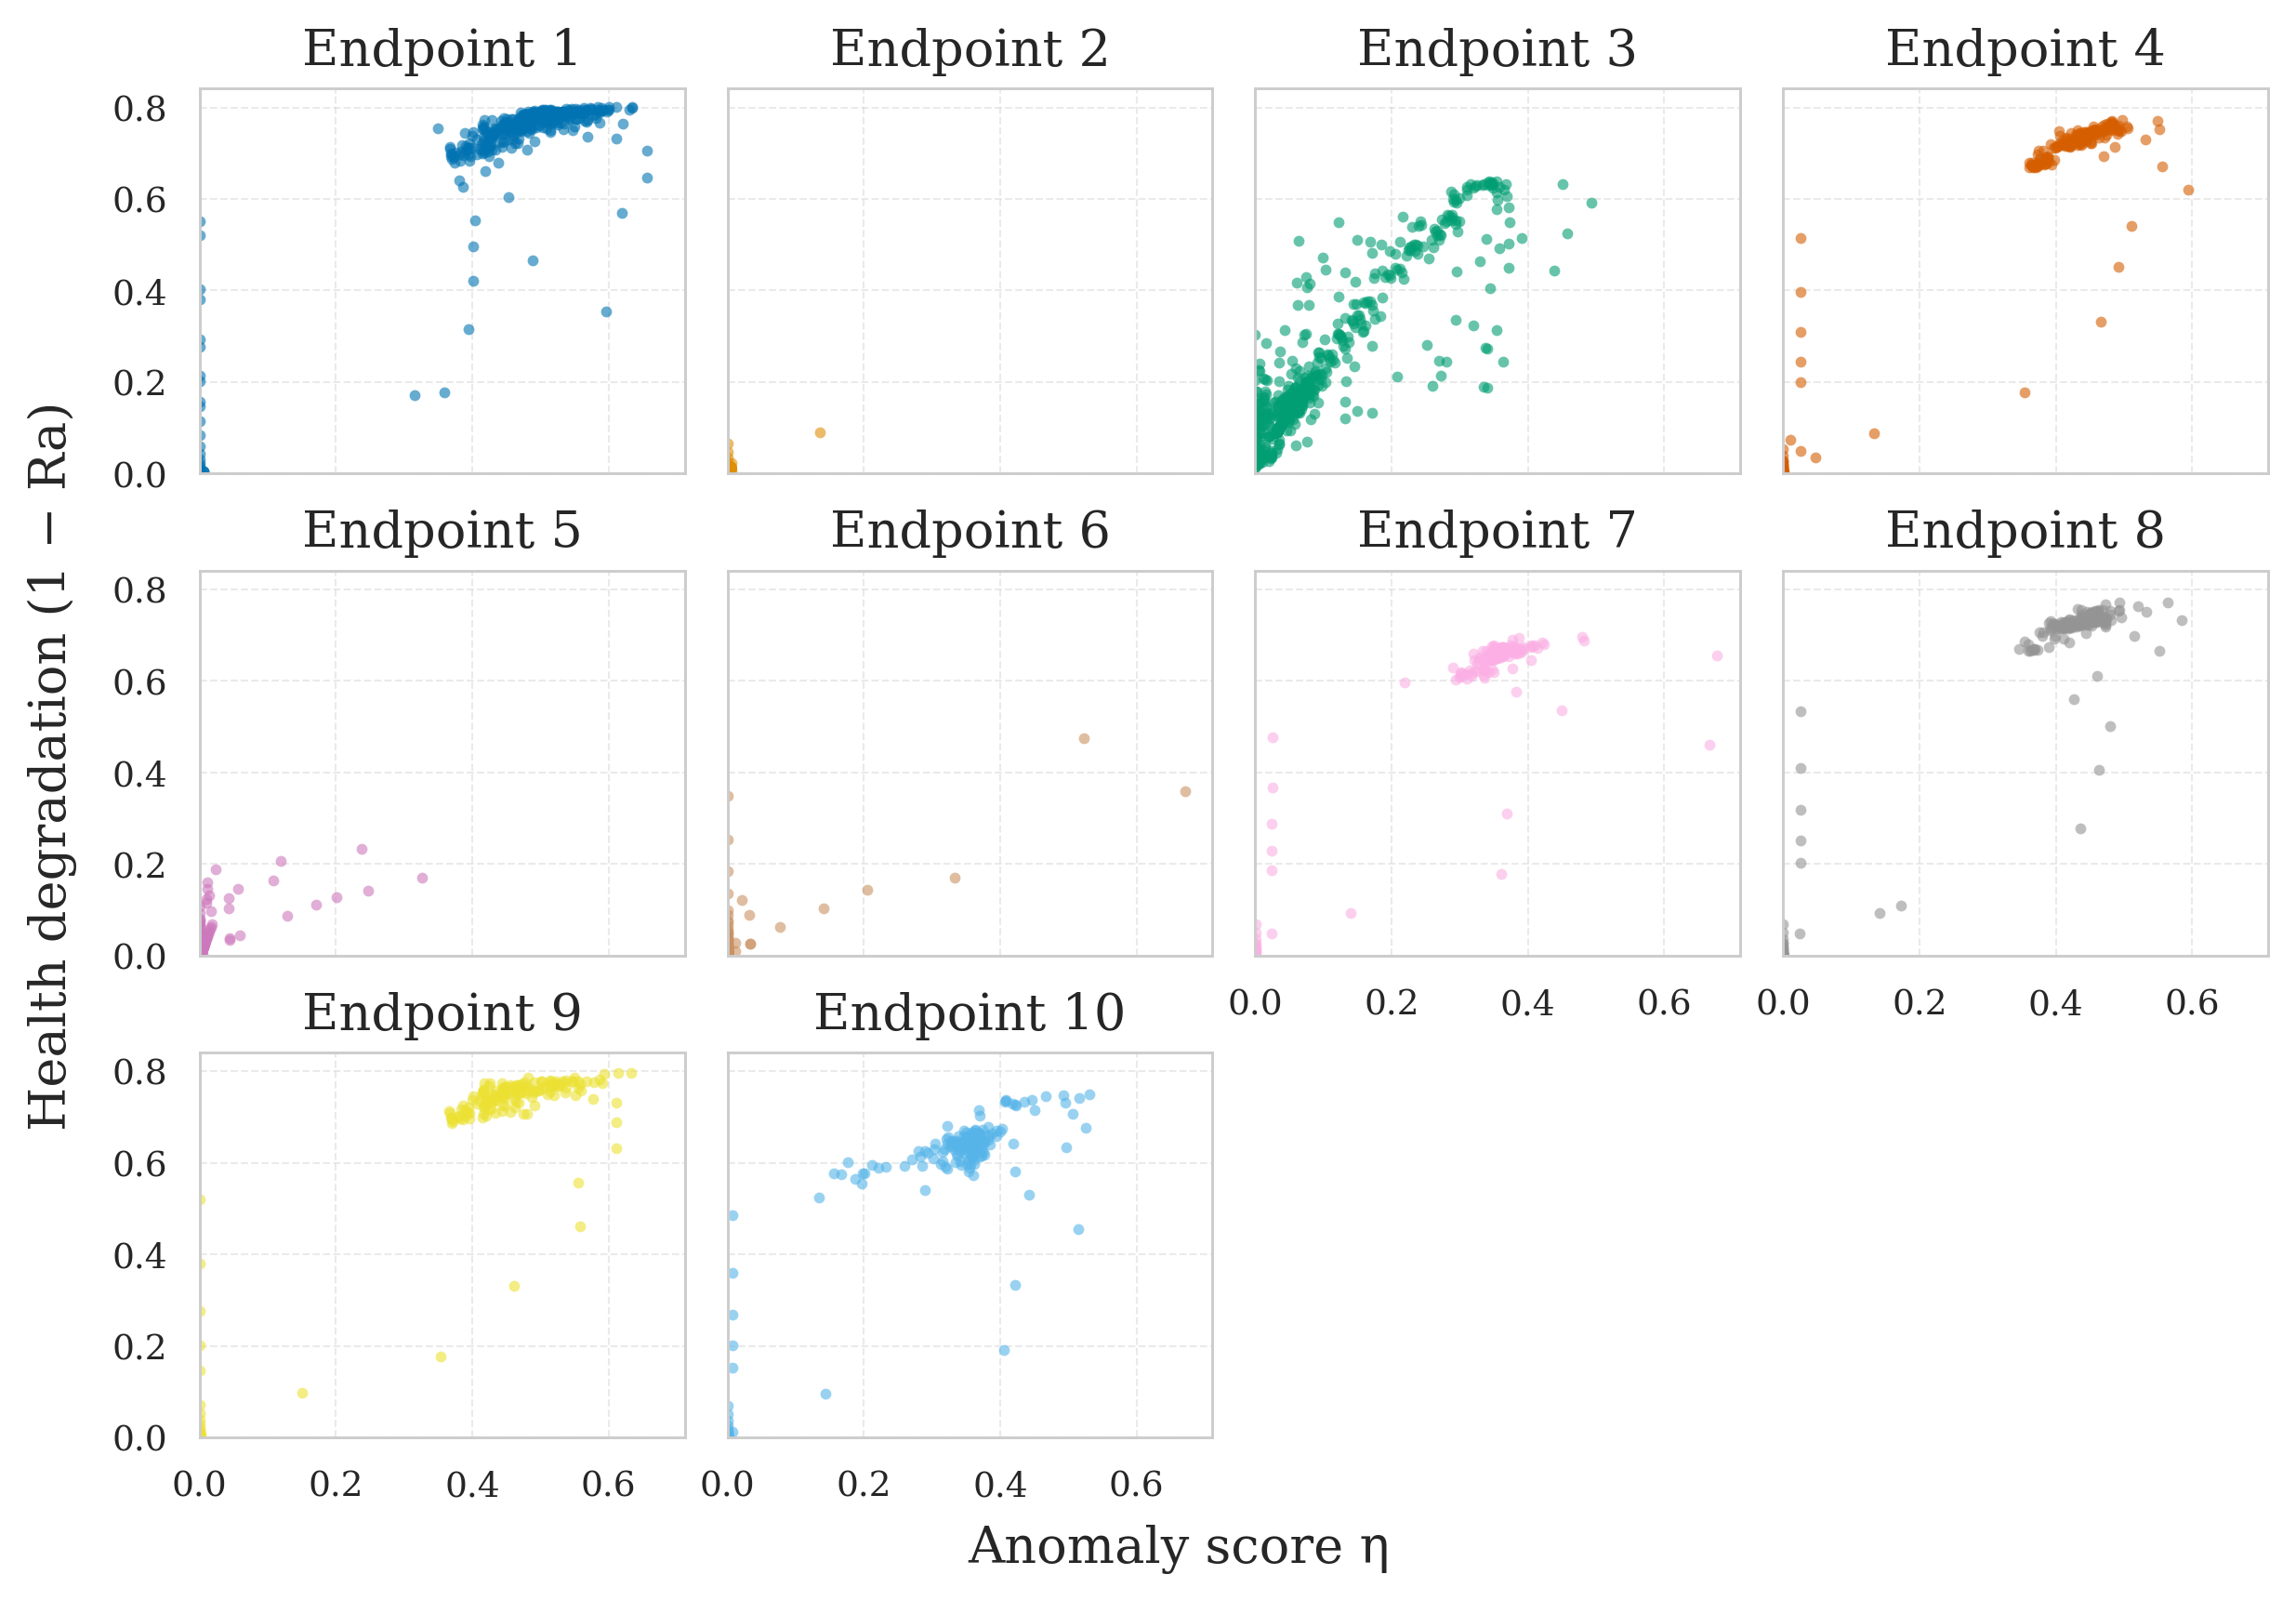

In [12]:
ra.plot_ra_vs_eta_grid(df_ra_win[df_ra_win['window_size'] == FIXED_WINDOW], col_wrap=4)

Below, it is provided a anomaly event profile of each endpoint. The anomaly frequency column states the percentage of the windows where anomaly begins, mean duration windows shows for how many windows the events happends, and total events comprises events as whole.

The anomaly analysis reveals that anomalies are rare but highly persistent across most endpoints. While the anomaly frequency is on the order of 10⁻³ events per window, the average duration reaches hundreds of windows in several endpoints, corresponding to several hours of sustained degradation. This indicates that anomalies correspond to structural state changes rather than transient fluctuations. Furthermore, the grid analysis shows a consistent monotonic relationship between anomaly score and degradation, confirming that η reliably captures persistent degradation regimes. Endpoint 10 exhibits a different behavior, with more frequent but shorter anomalies, suggesting higher volatility rather than sustained degradation.

In [13]:
summary = ra.build_anomaly_summary_table(df_ra_win[df_ra_win['window_size'] == FIXED_WINDOW])
summary

endpoint  anomaly_frequency  mean_duration_windows  total_events  \
0   Endpoint 1           0.002551                  208.0             2   
1   Endpoint 2           0.002551                    1.0             2   
2   Endpoint 3           0.001276                    1.0             1   
3   Endpoint 4           0.005102                   40.0             4   
4   Endpoint 5           0.003827                    1.0             3   
5   Endpoint 6           0.002551                    2.0             2   
6   Endpoint 7           0.002551                   78.5             2   
7   Endpoint 8           0.002551                   78.5             2   
8   Endpoint 9           0.002551                   78.5             2   
9  Endpoint 10           0.002551                   78.5             2   

   total_windows  
0            784  
1            784  
2            784  
3            784  
4            784  
5            784  
6            784  
7            784  
8            784  
9            784

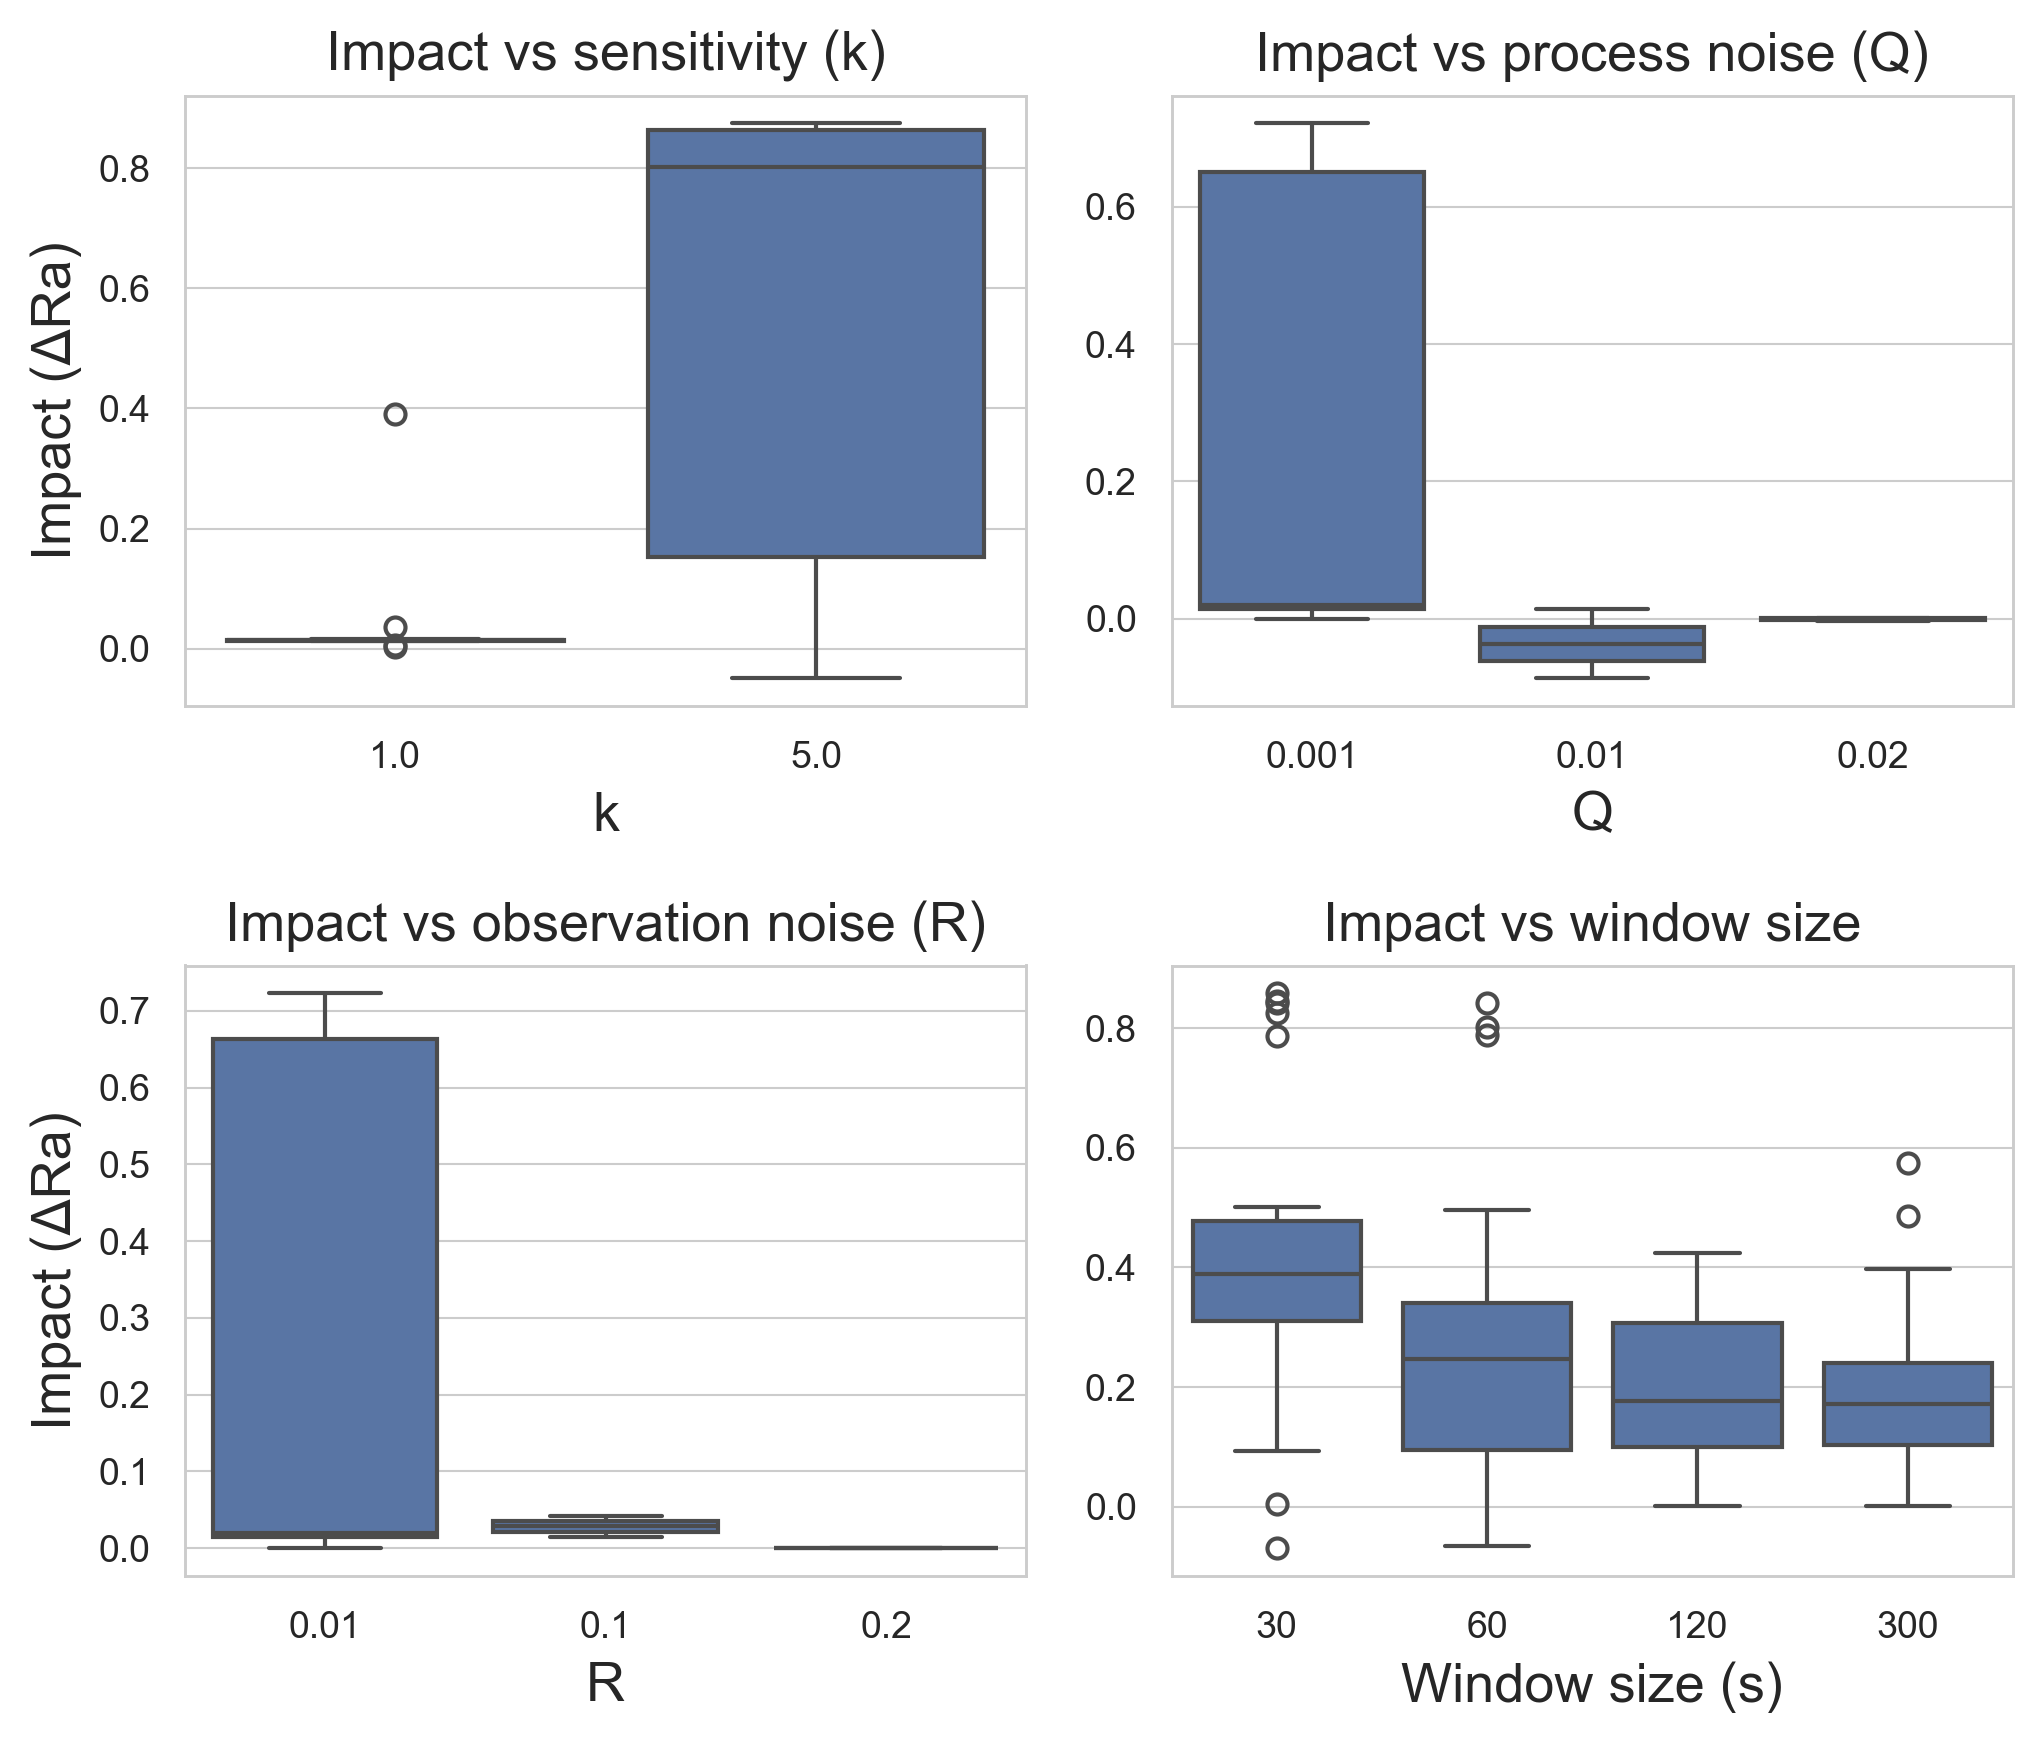

In [14]:
events_k = ra.extract_event_impacts(df_k)
events_Q = ra.extract_event_impacts(df_q)
events_R = ra.extract_event_impacts(df_r)
events_window = ra.extract_event_impacts(df_ra_win)
ra.plot_event_impact_grid(events_k, events_Q, events_R, events_window, figsize=(7,6))

The results demonstrate that the Kalman-based health indicator exhibits stable behavior across a wide range of process and observation noise parameters, while allowing sensitivity tuning through the observation sensitivity parameter k. This confirms the robustness and interpretability of the proposed estimator.

In [15]:
summary_k = ra.build_summary_table(df_k, "k")
summary_k

k   mean_Ra    std_Ra  mean_degradation  std_degradation
0  1.0  0.916909  0.137902          0.083091         0.137902
1  2.0  0.860667  0.227928          0.139333         0.227928
2  3.0  0.822038  0.287446          0.177962         0.287446
3  4.0  0.795071  0.327268          0.204929         0.327268
4  5.0  0.775901  0.354227          0.224099         0.354227

In [16]:
summary_q = ra.build_summary_table(df_q, "Q")
summary_q

Q   mean_Ra    std_Ra  mean_degradation  std_degradation
0  0.001  0.822026  0.284297          0.177974         0.284297
1  0.005  0.822038  0.287446          0.177962         0.287446
2  0.010  0.822044  0.288507          0.177956         0.288507
3  0.020  0.822047  0.289491          0.177953         0.289491

In [17]:
summary_r = ra.build_summary_table(df_r, "R")
summary_r

R   mean_Ra    std_Ra  mean_degradation  std_degradation
0  0.01  0.822046  0.289798          0.177954         0.289798
1  0.05  0.822038  0.287446          0.177962         0.287446
2  0.10  0.822034  0.286242          0.177966         0.286242
3  0.20  0.822050  0.284805          0.177950         0.284805

In [18]:
summary_window = ra.build_summary_table(df_ra_win, "window_size")
summary_window

window_size   mean_Ra    std_Ra  mean_degradation  std_degradation
0           30  0.881167  0.258642          0.118833         0.258642
1           60  0.875632  0.259122          0.124368         0.259122
2          120  0.867501  0.260946          0.132499         0.260946
3          300  0.854775  0.261701          0.145225         0.261701

Below, the chart shows the relationship between anomaly persistence and frequency across endpoints. Two distinct regimes emerge: persistent degradation, characterized by long anomaly durations and low frequency, and intermittent instability, characterized by short but frequent anomalies. Persistent regimes exhibit higher health degradation, confirming that sustained anomalies have a stronger impact on system health.

In [19]:
summary = ra.build_event_summary(df_ra_win[df_ra_win['window_size'] == FIXED_WINDOW])

In [20]:
ra.plot_regimes_clusters(summary, radius_offset=9, distance_threshold=0.01)

In [21]:
ra_metrics = ra.compute_ra_classification_metrics(df_ra_win)

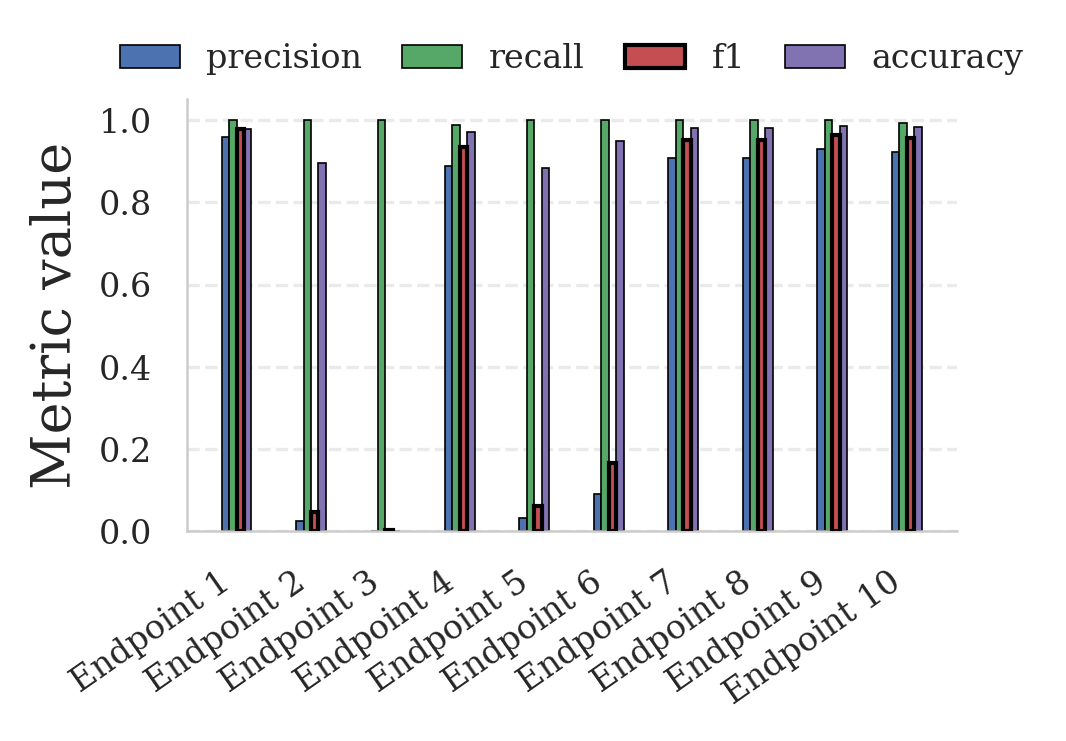

In [22]:
ra.plot_classification_metrics_bar(ra_metrics, window_size=FIXED_WINDOW)

In [23]:
for endpoint in df_ra_win[df_ra_win['window_size'] == FIXED_WINDOW]['endpoint'].unique():
    ra.plot_results(df_ra_win[df_ra_win['window_size'] == FIXED_WINDOW], anomalous_traffic_win_observations_df[anomalous_traffic_win_observations_df['window_size'] == FIXED_WINDOW], endpoint)

greatest anomaly at:2019-04-24 18:12:00 - begin plot:2019-04-24 18:02:00 - end plot:2019-04-24 19:12:00


greatest anomaly at:2019-04-25 14:48:00 - begin plot:2019-04-25 14:38:00 - end plot:2019-04-25 15:48:00


greatest anomaly at:2019-04-25 01:24:00 - begin plot:2019-04-25 01:14:00 - end plot:2019-04-25 02:24:00


greatest anomaly at:2019-04-24 18:20:00 - begin plot:2019-04-24 18:10:00 - end plot:2019-04-24 19:20:00


greatest anomaly at:2019-04-25 14:48:00 - begin plot:2019-04-25 14:38:00 - end plot:2019-04-25 15:48:00


greatest anomaly at:2019-04-24 18:16:00 - begin plot:2019-04-24 18:06:00 - end plot:2019-04-24 19:16:00


greatest anomaly at:2019-04-25 14:48:00 - begin plot:2019-04-25 14:38:00 - end plot:2019-04-25 15:48:00


greatest anomaly at:2019-04-25 14:48:00 - begin plot:2019-04-25 14:38:00 - end plot:2019-04-25 15:48:00


greatest anomaly at:2019-04-25 14:48:00 - begin plot:2019-04-25 14:38:00 - end plot:2019-04-25 15:48:00


greatest anomaly at:2019-04-25 14:48:00 - begin plot:2019-04-25 14:38:00 - end plot:2019-04-25 15:48:00


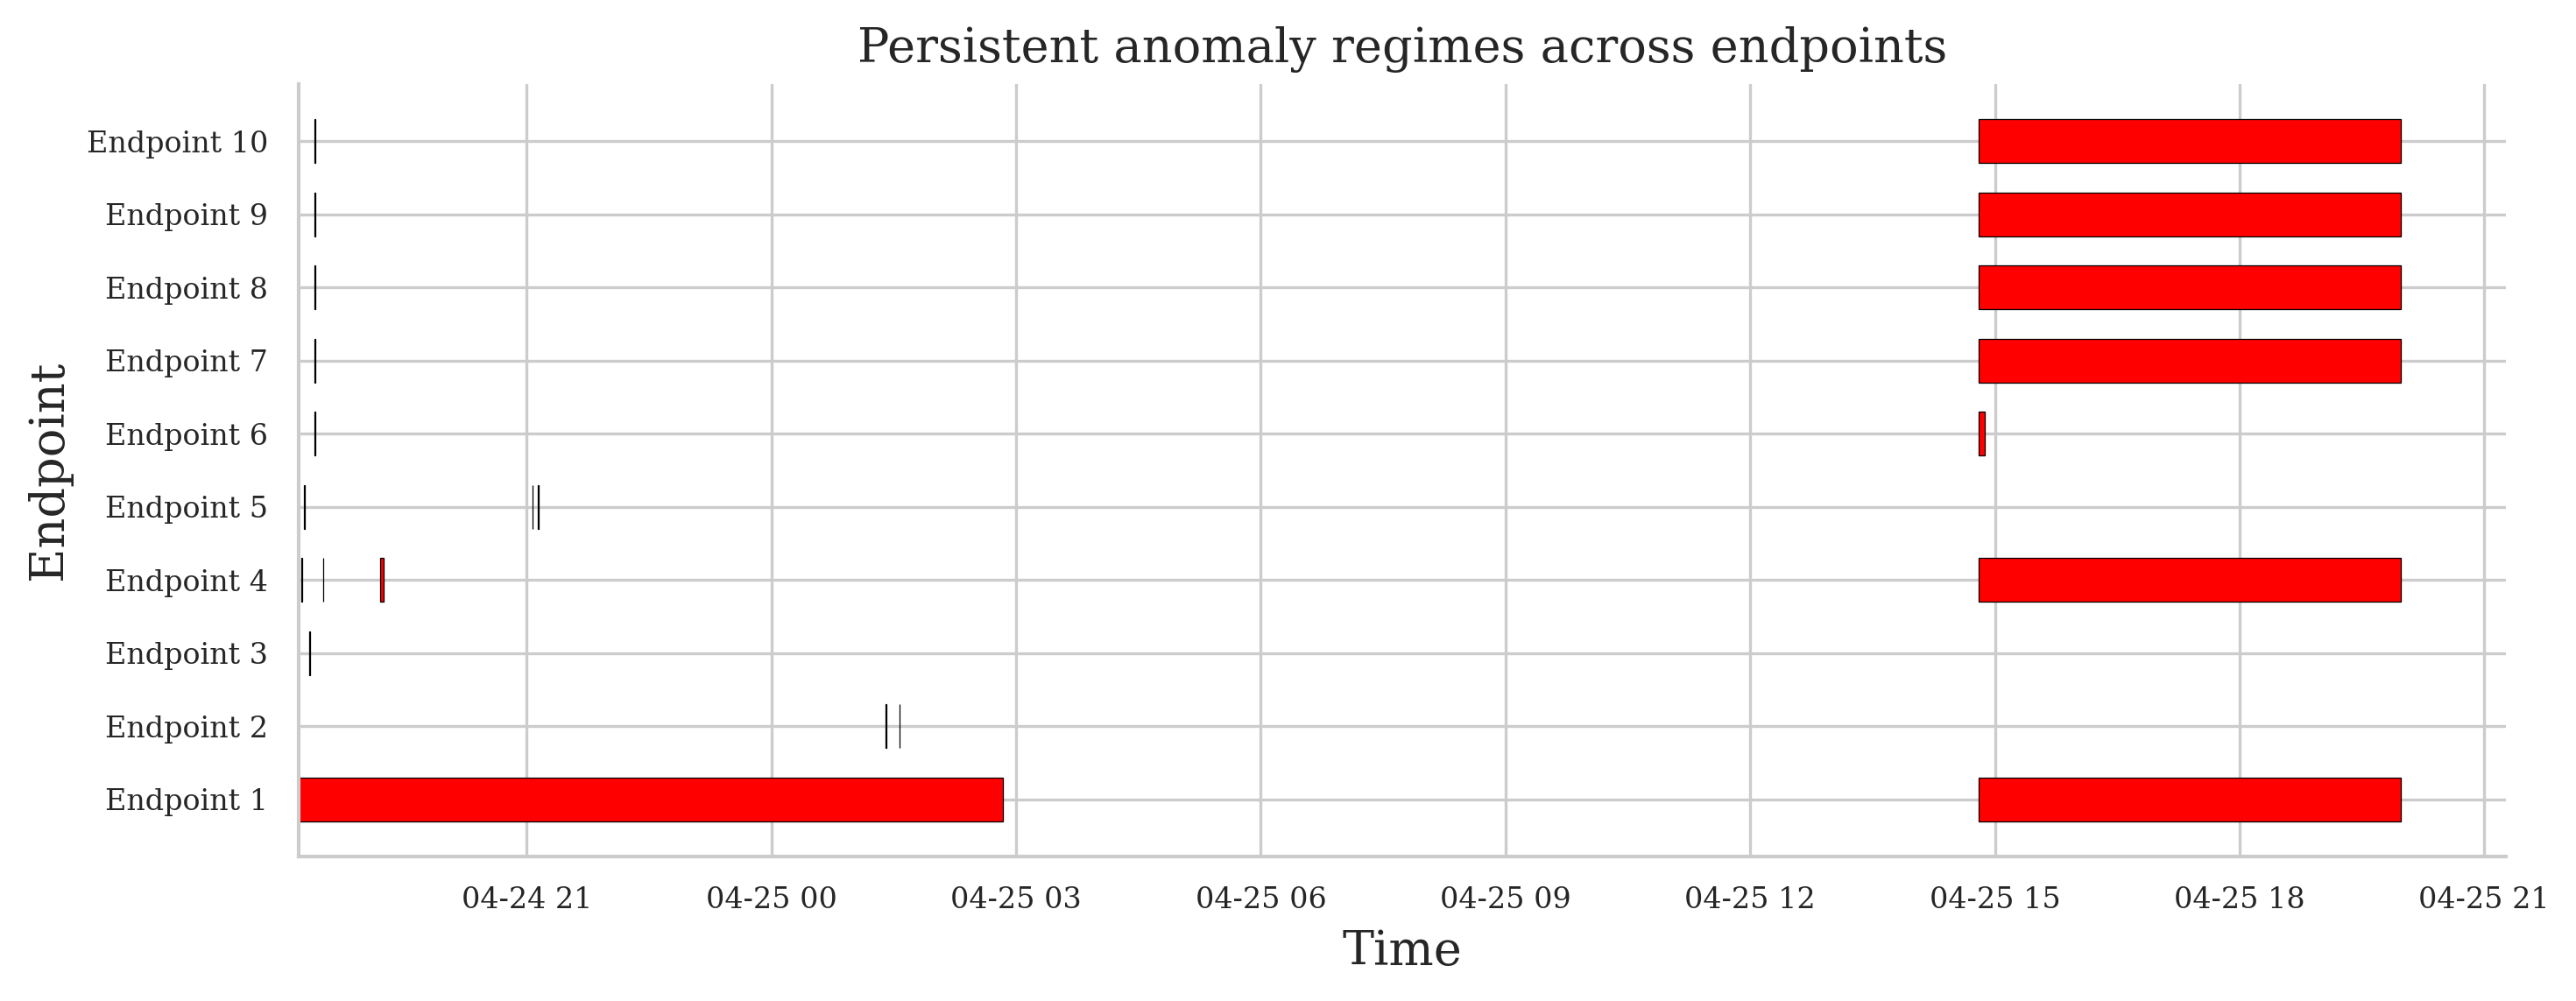

Rendered 22 anomaly blocks


In [24]:
ra.plot_anomaly_timeline_seaborn(df_ra_win[df_ra_win['window_size'] == FIXED_WINDOW])